In [1]:
'''
Multivariate Kalman Filter applied to simple 2-dimensional random walk
Daniel Rouhana
'''

'\nMultivariate Kalman Filter applied to simple 2-dimensional random walk\nDaniel Rouhana\n'

In [2]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import scipy.stats as stats

In [3]:
# Number of steps
n = 10000

# Create blank arrays, size of n
x_walk = np.zeros(n, dtype = np.float64)
y_walk = np.zeros(n, dtype = np.float64)

# Create blank arrays, size of 1 -- (n-1) will be appended to each
x_predict = np.array([0], dtype = np.float64)
y_predict = np.array([0], dtype = np.float64)

In [4]:
# Populate arrays iwth random steps
for i in range(1, n):
    temp = random.randint(1, 4)
    
    if temp == 1:
        x_walk[i] = x_walk[i - 1] + 1
        y_walk[i] = y_walk[i - 1]
    elif temp == 2:
        x_walk[i] = x_walk[i - 1] - 1
        y_walk[i] = y_walk[i - 1]
    elif temp == 3:
        x_walk[i] = x_walk[i - 1]
        y_walk[i] = y_walk[i - 1] + 1
    else:
        x_walk[i] = x_walk[i - 1]
        y_walk[i] = y_walk[i - 1] - 1

In [5]:
#  Combine Arrays
walk_data = np.c_[x_walk, y_walk]

In [6]:
###  Kalman Implementation  ###

#  Key:
#  X = state vector
#  F = state transition matrix
#  P = estimate covariance matrix
#  Q = process noise matrix
#  H = observation matrix
#  z_n = measurement vector (x and y coordinates of object -- this is the "input")
#  R = measurement uncertainty
#  K = kalman gain



# Initial Conditions
t = 1   # time between successive measurements (bin size)
sigma_a = 0.05   # random variance in acceleration
px, pdx, pddx, py, pdy, pddy = 10, 10, 10, 10, 10, 10   # variances -- since initial state vector is a guess, these values should be high
sigma_xm, sigma_ym = 3, 3   # measurement error standard deviation (are equal)



# Initial measurement Vector
z_n = np.array([[0],
                [0]])

# Initial state vector
X = np.array([[0],
              [0],
              [0],
              [0],
              [0],
              [0]])

# Initial state transition matrix
F = np.array([[1, t, 0.5 * t ** 2, 0, 0, 0],
              [0, 1, t, 0, 0, 0], 
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 1, t, 0.5 * t ** 2],
              [0, 0, 0, 0, 1, t],
              [0, 0, 0, 0, 0, 1]])

# Estimate covariance matrix
P = np.array([[px, 0, 0, 0, 0, 0],
              [0, pdx, 0, 0, 0, 0],
              [0, 0, pddx, 0, 0, 0],
              [0, 0, 0, py, 0, 0],
              [0, 0, 0, 0, pdy, 0],
              [0, 0, 0, 0, 0, pddy]])

# Observation matrix
H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0]])

# Process noise matrix for constant acceleration model
Q = np.array([[t ** 4 / 4, t ** 3 / 2, t ** 2 / 2, 0, 0, 0],
              [t ** 3 / 2, t ** 2 / 2, t, 0, 0, 0],
              [t ** 2 / 2, t, 1, 0, 0, 0],
              [0, 0, 0, t ** 4 / 4, t ** 3 / 2, t ** 2 / 2],
              [0, 0, 0, t ** 3 / 2, t ** 2 / 2, t],
              [0, 0, 0, t ** 2 / 2, t, 1]]).dot(sigma_a)

# Measurement uncertainty (assumed constant for simplicity)
R = np.array([[sigma_xm ** 2, 0],
              [0, sigma_ym ** 2]])

In [7]:
###  Kalman Equations  ###


# STATE EXTRAPOLATION EQUATION
def state_extrapolation(X_, F_):
    X_extr = F_.dot(X_)
    return X_extr


# COVARIANCE EXTRAPOLATION EQUATIONS
def cov_extrapolation(P_, Q_, F_):
    P_extr = F_.dot(P).dot(F_.T) + Q_
    return P_extr


# KALMAN GAIN EQUATION
def calculate_KG(P_, H_, R_):
    first = P_.dot(H.T)
    second = H_.dot(P_).dot(H_.T) + R_
    third = np.reciprocal(second, where = second != 0)
    K_ = first.dot(third)
    return K_


# STATE UPDATE EQUATION
def state_update(z_, H_, X_, K_):
    first = z_ - H_.dot(X_)
    second = K_.dot(first)
    X_updated = X_ + second
    return X_updated


# COVARIANCE UPDATE EQUATION
def covariance_update(K_, H_, R_, P_):
    first = np.eye(6) - K_.dot(H_)
    second = first.T
    third = K_.dot(R_).dot(K_.T)
    P_updated = first.dot(P_).dot(second) + third
    return P_updated

In [8]:
#  Initialization
P_p = cov_extrapolation(P, Q, F)
X_p = state_extrapolation(X, F)

In [9]:
#  Main Loop

for data in walk_data[1:]:
    # Step 1: Measure
    z_n = np.array([[data[0]],
                    [data[1]]])
    
    # Step 2: Update
    K = calculate_KG(P_p, H, R)           # Kalman Gain
    X_c = state_update(z_n, H, X_p, K)      # State
    P_c = covariance_update(K, H, R, P_p)   # Estimate uncertainty (covariance)
    
    # Step 3: Predict
    X_p = state_extrapolation(X_c, F)     # State
    P_p = cov_extrapolation(P_c, Q, F)    # Prediction uncertainty (covariance)
    
    x_predict = np.append(x_predict, X_p[0])
    y_predict = np.append(y_predict, X_p[3])

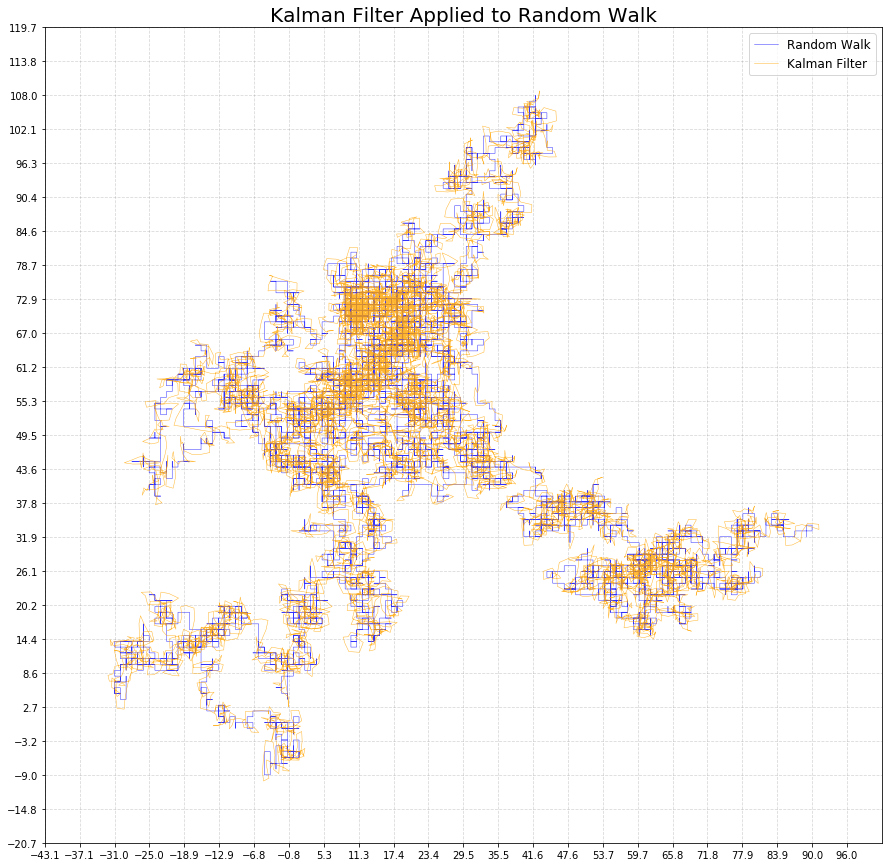

In [10]:
# Create plot
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(1, 1, 1)

# Autogenerate graph dimensions
xmin, xmax = x_walk.min(), x_walk.max()
ymin, ymax = y_walk.min(), y_walk.max()
xint = (xmax - xmin) / 20
yint = (ymax - ymin) / 20
xborder = xint * 2
yborder = yint * 2

# Axes
ax.set_xlim([xmin - xborder, xmax + xborder])
ax.set_ylim([ymin - yborder, ymax + yborder])

# Line
random_walk = ax.plot(x_walk, y_walk, lw = 0.5, color = 'blue', aa = True, alpha = 0.8, label = 'Random Walk')
kalman_filter = ax.plot(x_predict, y_predict, lw = 0.5, color = 'orange', aa = True, alpha = 0.8, label = 'Kalman Filter')

# Title, legend
ax.set_title('Kalman Filter Applied to Random Walk', fontsize = 20)
ax.legend(fontsize = 12)

# Tick marks
ax.set_xticks(np.arange(xmin - xborder, xmax + xborder, xint))
ax.set_yticks(np.arange(ymin - yborder, ymax + yborder, yint))

# Grid lines
ax.grid(True, which = 'major', linestyle = '--', color = 'gray', alpha = 0.3)

plt.show()

In [11]:
### Statistical Testing ###

y_cov = np.cov(y_predict, y_walk)
x_cov = np.cov(x_predict, x_walk)
x_ktau = stats.kendalltau(x_predict, x_walk)
y_ktau = stats.kendalltau(y_predict, y_walk)
x_pear = stats.pearsonr(x_predict, x_walk)
y_pear = stats.pearsonr(y_predict, y_walk)
x_tt_i = stats.ttest_ind(x_predict, x_walk)
y_tt_i = stats.ttest_ind(y_predict, y_walk)
x_tt_rel = stats.ttest_rel(x_predict, x_walk)
y_tt_rel = stats.ttest_rel(y_predict, y_walk)

In [12]:
print('Kalman Filter Statistical Analysis:\n\n'
      'Measure                   x-values                   y-values\n'
      '________________________________________________________________________\n\n'
     f'Pearson Corr.             {x_pear[0]}         {y_pear[0]}\n\n'
     f'Kendall Tau Corr.         {x_ktau[0]}         {y_ktau[0]}\n\n'
     f'Independent T-test        {x_tt_i[1]}         {y_tt_i[1]}\n\n\n'
      
     f'X-Axes Covariance: \n{x_cov}\n\n'
     f'Y-Axes Covariance: \n{y_cov}\n'
     )

Kalman Filter Statistical Analysis:

Measure                   x-values                   y-values
________________________________________________________________________

Pearson Corr.             0.9995873251396754         0.9995490307773808

Kendall Tau Corr.         0.9827624709785355         0.9841864186906467

Independent T-test        0.9788316130979104         0.9916757173634


X-Axes Covariance: 
[[570.06715093 569.11769325]
 [569.11769325 568.63904614]]

Y-Axes Covariance: 
[[511.77864769 511.17164749]
 [511.17164749 511.02617746]]



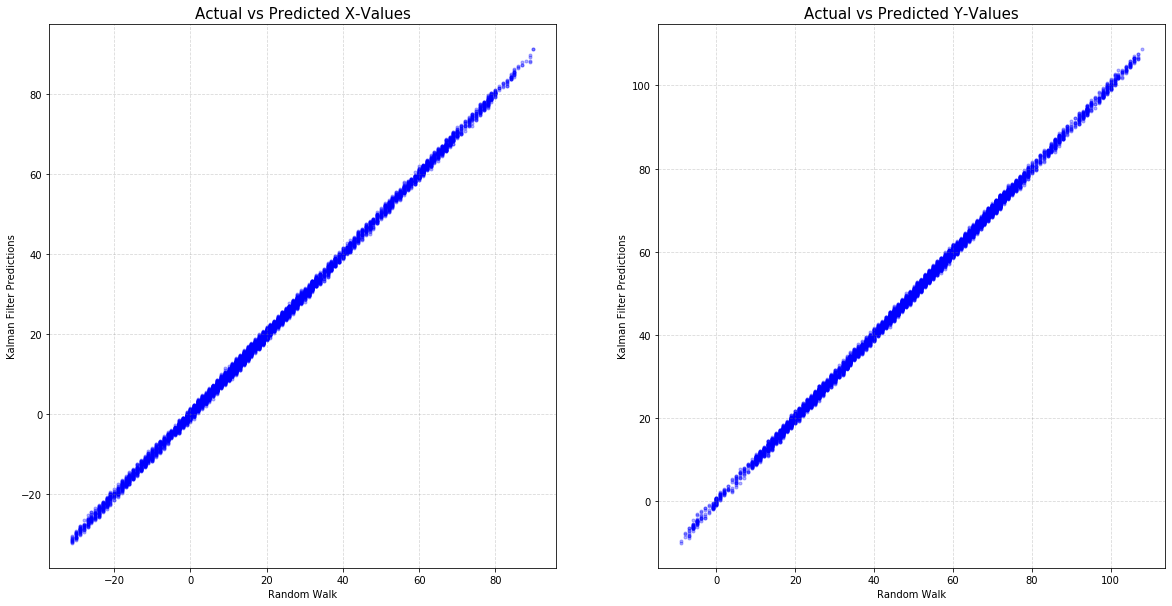

In [13]:
# Create figure and plots
fig2 = plt.figure(figsize = (20, 10))
ax1 = fig2.add_subplot(1, 2, 1)
ax2 = fig2.add_subplot(1, 2, 2)

# Formatting
ax1.set_title('Actual vs Predicted X-Values', fontsize = 15)
ax2.set_title('Actual vs Predicted Y-Values', fontsize = 15)
ax1.grid(True, which = 'major', linestyle = '--', color = 'gray', alpha = 0.3)
ax2.grid(True, which = 'major', linestyle = '--', color = 'gray', alpha = 0.3)
ax1.set_xlabel('Random Walk')
ax1.set_ylabel('Kalman Filter Predictions')
ax2.set_xlabel('Random Walk')
ax2.set_ylabel('Kalman Filter Predictions')

# Plot data
ax1.scatter(x_walk, x_predict, color = 'blue', alpha = 0.3, marker = '.')
ax2.scatter(y_walk, y_predict, color = 'blue', alpha = 0.3, marker = '.')